In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# --- Path Dataset dan Label ---
base_path = '/content/drive/MyDrive/HANA/Palm ripeness dataset(background)'
labels = ['Masak(b)', 'Mengkal(b)', 'Mentah(b)']
data = []

In [ ]:
# %% [code]
# 3. Ekstrak RGB rata-rata dari gambar (tanpa menghapus background)
def extract_rgb(image_path):
    img = cv2.imread(image_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return rgb.mean(axis=(0, 1))  # Rata-rata RGB dari seluruh gambar (tanpa background)

In [ ]:
# 4. Ekstrak fitur GLCM dari grayscale
def extract_glcm_features(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances=[5], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return contrast, correlation, energy, homogeneity

In [ ]:
# %% [code]
# --- PROSES EKSTRAKSI RGB + GLCM ---
for label in labels:
    folder = os.path.join(base_path, label)
    if not os.path.exists(folder):
        print(f"Folder tidak ditemukan: {folder}")
        continue

    for filename in tqdm(os.listdir(folder), desc=f"Memproses {label}"):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepath = os.path.join(folder, filename)
            try:
                r, g, b = extract_rgb(filepath)
                contrast, corr, energy, homog = extract_glcm_features(filepath)
                data.append([filename, r, g, b, contrast, corr, energy, homog, label])
            except Exception as e:
                print(f"Gagal memproses {filename}: {e}")


Memproses Mentah(b): 100%|██████████| 91/91 [03:26<00:00,  2.27s/it]


In [8]:
# %% [code]
# --- Buat Tabel Data ---
df = pd.DataFrame(data, columns=[
    'Filename', 'R', 'G', 'B', 'Contrast', 'Correlation', 'Energy', 'Homogeneity', 'Label'
])

# --- Tampilkan 254 baris pertama dari tabel hasil ekstraksi ---
print("🔹 Contoh 254 baris fitur RGB + GLCM:")
print(df.head(254))

🔹 Contoh 254 baris fitur RGB + GLCM:
            Filename           R           G           B     Contrast  \
0     masak (16).png  104.412620   84.482069   83.981893  2705.207501   
1     masak (17).JPG  117.397238   92.881479   92.313397   268.977916   
2     masak (10).JPG  127.195111  109.557199   95.184847   342.824037   
3     masak (11).JPG  115.928443   99.768484   91.735542   315.878344   
4     masak (12).JPG  121.934743  109.224125  114.006754   278.356772   
..               ...         ...         ...         ...          ...   
249  mentah (89).JPG  105.290551  106.164162  112.182498   493.710794   
250  mentah (90).JPG   90.912925   86.031927   81.020138   144.121710   
251  mentah (82).JPG  119.712600  117.854523  110.146261   444.788846   
252  mentah (91).JPG  100.972182  101.086899  101.399198   300.202759   
253   mentah (9).JPG  114.102079  113.396081  108.317773   770.700408   

     Correlation    Energy  Homogeneity      Label  
0       0.440916  0.007453     0.

In [9]:
# %% [code]
# --- Simpan ke Excel ---
df.to_excel('/content/drive/MyDrive/HANA/GABUNGAN RGB & GLCM CODE NEW/RGB_GLCM_Output_Background.xlsx', index=False)

# --- IMPOR LIBRARY YANG DIBUTUHKAN ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# --- PILIH FITUR & LABEL ---
X = df[['R', 'G', 'B', 'Contrast', 'Correlation', 'Energy', 'Homogeneity']]
y = df['Label']

# --- NORMALISASI FITUR ---
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# --- SPLIT DATA dan LATIH MODEL ---
X = df[['R', 'G', 'B', 'Contrast', 'Correlation', 'Energy', 'Homogeneity']]
y = df['Label']

# --- split data data latih 80: 20 data uji ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
# Membuat DataFrame dengan Filename, Label Aktual dan Label Prediksi
results = pd.DataFrame({
    'Filename': df.loc[y_test.index, 'Filename'],  # Mengambil nama file berdasarkan indeks data uji
    'Label Aktual': y_test,
    'Label Prediksi': y_pred
})

# Menyimpan hasil ke dalam file CSV
results.to_csv('/content/drive/MyDrive/HANA/hasil_klasifikasi_background.csv', index=False)

# Menampilkan hasilnya
print(results.head())  # Tampilkan 5 baris pertama dari tabel

             Filename Label Aktual Label Prediksi
190   mentah (39).jpg    Mentah(b)      Mentah(b)
6      masak (15).JPG     Masak(b)     Mengkal(b)
79     masak (82).jpg     Masak(b)       Masak(b)
205   mentah (48).jpg    Mentah(b)      Mentah(b)
117  mengkal (34).JPG   Mengkal(b)       Masak(b)


In [12]:
# Membuat Tabel Kontingensi
contingency_table = pd.crosstab(y_test, y_pred, rownames=['Label Aktual'], colnames=['Label Prediksi'])

# Menampilkan Tabel Kontingensi
print(contingency_table)

# Simpan Tabel Kontingensi ke CSV jika diperlukan
contingency_table.to_csv('/content/drive/MyDrive/HANA/tabel_kontingensi_background.csv', index=True)

Label Prediksi  Masak(b)  Mengkal(b)  Mentah(b)
Label Aktual                                   
Masak(b)              10           7          1
Mengkal(b)             2           5          2
Mentah(b)              0           1         23



✅ Akurasi Model: 74.51%

📊 Classification Report:
              precision    recall  f1-score   support

    Masak(b)       0.83      0.56      0.67        18
  Mengkal(b)       0.38      0.56      0.45         9
   Mentah(b)       0.88      0.96      0.92        24

    accuracy                           0.75        51
   macro avg       0.70      0.69      0.68        51
weighted avg       0.78      0.75      0.75        51



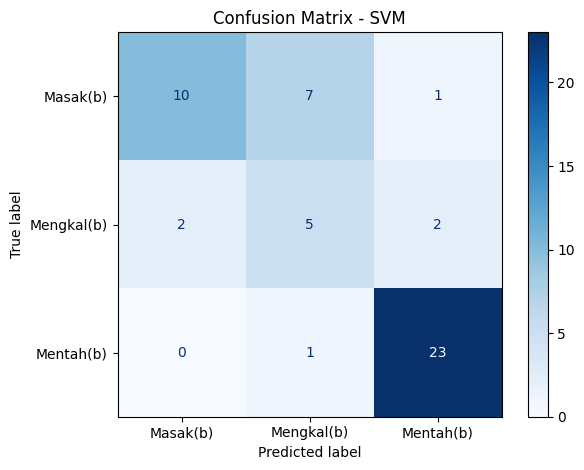

In [22]:
  # --- EVALUASI HASIL SVM ---
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Akurasi Model: {acc*100:.2f}%")

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# --- VISUALISASI CONFUSION MATRIX UNTUK SVM ---
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.tight_layout()
plt.show()

In [17]:
len(X_test)

51